## RNN + LSTM을 위한 공부-1
#### 순차 데이터와 순환 신경망

순차데이터: 텍스트나 시계열 데이터와 같이 순서에 의미가 있는 데이터

-> 순차데이터를 다룰 때는 이전에 입력한 데이터를 기억하는 기능이 필요함

층 == 셀(cell), 셀의 출력을 은닉상태라고 함

샘플을 처리하는 한 단계를 타임스텝이라고 함

일반적으로 은닉층의 활성화 함수로는 tanh를 사용.

순환 신경망은 이전 타임스텝의 은닉상태에 곱해지는 가중치도 있다.

h0(타임스텝 1에서 사용)은 0임

### 이전 타임스텝의 은닉 상태는 다음 타임스텝의 뉴런에 완전 연결됨.

하나의 샘플은 시퀀스 길이 + 단어 표현의 2차원 배열임 -> 순환층을 통과하면 1차원 배열로 바뀜  
해당 크기는 뉴런 개수에 의해 결정됨

순환 신경망도 여러 개의 층을 쌓을 수 있는데 만약 두 개의 셀을 연결한다 생각하면 첫 번째 셀은 두 번째 셀에 입력을 줄 때 2차원 배열로 주기 위해서 모든 타임스텝의 은닉 상태를 출력하고 두 번째 셀은 원래 셀이 출력하듯이 마지막 타임스텝의 은닉 상태만 출력한다.

순환신경망도 다중분류일 경우에는 출력층에 클래스 개수만큼 뉴런을 두고 소프트맥스 함수를 사용하고 이진 분류일 경우에는 하나의 뉴런을 두고 시그모이드 활성화 함수를 사용함.

## RNN + LSTM을 위한 공부-2
#### 순환 신경망으로 IMDB 리뷰 분류하기

텍스트 데이터의 경우 단어를 숫자 데이터로 바꾸는 일반적인 방법은 데이터에 등장하는 단어마다 고유한 정수를 부여하는 것임. 공백을 기준으로 하고 부린된 단어를 토큰이라고 부름  
여기서 토큰에 할당 된 정수 중에 0은 패딩 1은 문장의 시작 2는 어휘 사전에 없는 토큰으로 사용.

어휘사전: 훈련 세트에서 고유한 단어를 뽑아 만든 목록

In [2]:
from tensorflow.keras.datasets import imdb
(train_input, train_target), (test_input, test_target) = imdb.load_data(num_words=500)

17464789/17464789 [==============================] - 3s 0us/step


In [5]:
print(train_input.shape, test_input.shape) #25000개의 샘플 

(25000,) (25000,)


In [7]:
print(len(train_input[0]))
print(len(train_input[1]))

218
189


In [8]:
print(train_input[0])

[1, 14, 22, 16, 43, 2, 2, 2, 2, 65, 458, 2, 66, 2, 4, 173, 36, 256, 5, 25, 100, 43, 2, 112, 50, 2, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 2, 2, 17, 2, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2, 19, 14, 22, 4, 2, 2, 469, 4, 22, 71, 87, 12, 16, 43, 2, 38, 76, 15, 13, 2, 4, 22, 17, 2, 17, 12, 16, 2, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2, 2, 16, 480, 66, 2, 33, 4, 130, 12, 16, 38, 2, 5, 25, 124, 51, 36, 135, 48, 25, 2, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 2, 15, 256, 4, 2, 7, 2, 5, 2, 36, 71, 43, 2, 476, 26, 400, 317, 46, 7, 4, 2, 2, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2, 56, 26, 141, 6, 194, 2, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 2, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 2, 88, 12, 16, 283, 5, 16, 2, 113, 103, 32, 15, 16, 2, 19, 178, 32]


IMDB데이터는 이미 정수로 변환되어 있음

In [11]:
print(train_target[:20])

[1 0 0 1 0 0 1 0 1 0 1 0 0 0 0 0 1 1 0 1]


In [12]:
from sklearn.model_selection import train_test_split

In [14]:
train_input, val_input, train_target, val_target = train_test_split(train_input, train_target, test_size=0.2, random_state=42)

### 우선 리뷰 길이의 평균, 최소, 최대를 확인

In [15]:
import numpy as np
lengths = np.array([len(x) for x in train_input])

In [17]:
print(np.mean(lengths), np.median(lengths))

239.00925 178.0


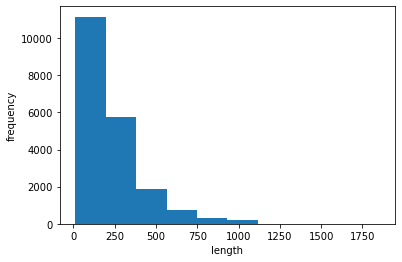

In [18]:
import matplotlib.pyplot as plt
plt.hist(lengths)
plt.xlabel('length')
plt.ylabel('frequency')
plt.show()

대부분의 리뷰 길이는 300 미만 (편향)

In [19]:
from tensorflow.keras.preprocessing.sequence import pad_sequences #패딩시켜주는 좋은 친구
train_seq = pad_sequences(train_input, maxlen=100)

In [21]:
print(train_seq.shape) #원래 20000개의 객체 1차원 배열이었는데 패딩 후 2차원 배열이 됨

(20000, 100)


In [22]:
print(train_seq[0])

[ 10   4  20   9   2 364 352   5  45   6   2   2  33 269   8   2 142   2
   5   2  17  73  17 204   5   2  19  55   2   2  92  66 104  14  20  93
  76   2 151  33   4  58  12 188   2 151  12 215  69 224 142  73 237   6
   2   7   2   2 188   2 103  14  31  10  10 451   7   2   5   2  80  91
   2  30   2  34  14  20 151  50  26 131  49   2  84  46  50  37  80  79
   6   2  46   7  14  20  10  10 470 158]


In [23]:
print(train_input[0][-10:])# 원본 데이터의 ㅁ자ㅣ막 10개의 토큰과 seq한 데이터의 마지막 10개가 똑같음 -> 앞에서부터 잘랐다. Y? -> 뒤에 나오는 말이 더 중요하다고 판단

[6, 2, 46, 7, 14, 20, 10, 10, 470, 158]


In [24]:
print(train_seq[5])

[  0   0   0   0   1   2 195  19  49   2   2 190   4   2 352   2 183  10
  10  13  82  79   4   2  36  71 269   8   2  25  19  49   7   4   2   2
   2   2   2  10  10  48  25  40   2  11   2   2  40   2   2   5   4   2
   2  95  14 238  56 129   2  10  10  21   2  94 364 352   2   2  11 190
  24 484   2   7  94 205 405  10  10  87   2  34  49   2   7   2   2   2
   2   2 290   2  46  48  64  18   4   2]


In [25]:
val_seq = pad_sequences(val_input, maxlen=100)

### 순환 신경망 만들기

In [28]:
from tensorflow import keras
model = keras.Sequential()
model.add(keras.layers.SimpleRNN(8, input_shape = (100, 500)))
model.add(keras.layers.Dense(1, activation='sigmoid'))

위에서 simplernn으로 층을 만들 때 input_shape의 두번째 매개변수값을 500으로 해준 이유는 정수 사이에는 어떤 관련도 없는데 정수값에 따라 출력이 바뀌기 때문에 이를 방지하기 위해 원-핫인코딩을 해주기 위해서 500으로 한것이다.

In [29]:
train_oh = keras.utils.to_categorical(train_seq)

In [31]:
print(train_oh.shape)

(20000, 100, 500)


In [33]:
print(train_oh[0][0][:12])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


In [34]:
print(np.sum(train_oh[0][0]))

1.0


In [35]:
val_oh = keras.utils.to_categorical(val_seq)

In [36]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 8)                 4072      
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 4,081
Trainable params: 4,081
Non-trainable params: 0
_________________________________________________________________


500*8 + 8*8 + 8 = 4072 -> 원-핫 인코딩으로 인한 배열 * 뉴런 8개 + 뉴런의 은닉 상태 크기 8 * 뉴런 개수 8 + 절편(뉴런 개수) 8

In [39]:
rmsprop = keras.optimizers.RMSprop(learning_rate = 1e-4)
model.compile(optimizer= rmsprop, loss='binary_crossentropy', metrics=['accuracy'])
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-simplernn-model.h5', save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience =3, restore_best_weights=True)
history = model.fit(train_oh, train_target, epochs=100, batch_size=64, validation_data = (val_oh, val_target), callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/100
313/313 [==============================] - ETA: 0s - loss: 0.7009 - accuracy: 0.5107


KeyboardInterrupt



CPU 사용을 위해 여기서부턴 코렙으로